In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wave
from playsound import playsound as play

%matplotlib inline

In [32]:
# This is the algorithm for computing DTFT of given signal
# The parameters for this Algorithm is a signal of shape (2, N) or  (N, )
# it has some default parameters like lower limit, higher limit and Number of points for omega axis

def dtft(signal, low_lim=-1*np.pi, high_lim=np.pi, N=100, endpoints=False):
    w = np.linspace(low_lim, high_lim, N, endpoint=endpoints)                  #Array of omega values
    e_jw = np.exp(w*1j)                                                    #computes e^{jw}
    
    # Creates a dictnationry to store dtft, Magnitude, Phase and omega
    dtft = dict()        
    # Creates a empty array for dtft
    dtft['complex'] = np.zeros(N, dtype=complex) 
    # Assiging omega values 
    dtft['omega'] = w
    
    # The following conditional statements are for checking whether the input(signal) is been provided with 
    # time stamps
    if signal.ndim == 2:
        for i in range(signal.shape[1]):
            dtft['complex'] += signal[0, i]*np.power(e_jw, -1*signal[1, i])
    else:
        for i in range(signal.shape[0]):
            dtft['complex'] += signal[i]*np.power(e_jw, -1*i)

    # Rounds-off the result upto 4 decimal places
    dtft['complex'] = np.round(dtft['complex'], decimals=4)
    # Finds the magnitude of the dtft computed above.
    dtft['magnitude'] = np.absolute(dtft['complex'])
    # Finds the phase of dtft in radians which lies in the range[-pi, pi]
    dtft['phase'] = np.angle(dtft['complex'], deg=0)
    return dtft

# This function is used for plotting Real part, Imaginary part, Magnitude and Phase for a given DTFT

def dtft_plotter(dtft, title=None, complex_part=True):
    plt.rcParams['figure.figsize'] = [10, 8]
    
    if complex_part:
        fig, ax = plt.subplots(2,2)

        if title != None:
            fig.suptitle(title, fontweight="bold")

        ax[0, 0].title.set_text('Real Part')
        ax[0, 0].stem(dtft['omega'], np.real(dtft['complex']))
        ax[0, 0].set(ylabel='$Re\{X(e^{j \omega})\}$')

        ax[0, 1].title.set_text('Imaginary Part')
        ax[0, 1].stem(dtft['omega'], np.imag(dtft['complex']), 'tab:red')
        ax[0, 1].yaxis.tick_right()
        ax[0, 1].set(ylabel='$Im\{X(e^{j \omega})\}$')

        ax[1, 0].title.set_text('Magnitude')
        ax[1, 0].stem(dtft['omega'], dtft['magnitude'], 'tab:orange')
        ax[1, 0].set(xlabel='$\omega$', ylabel='$|X(e^{j \omega})|$')

        ax[1, 1].title.set_text('Phase')
        ax[1, 1].stem(dtft['omega'], dtft['phase'], 'tab:green')
        ax[1, 1].yaxis.tick_right()        
        ax[1, 1].set(xlabel='$\omega$', ylabel='$\phi$(in radians)')
    else:
            
        fig, (ax1, ax2) = plt.subplots(1, 2)
        if title != None:
            fig.suptitle(title, fontweight="bold")
        ax1.stem(dtft['omega'],dtft['magnitude'])
        ax1.set(xlabel='$\omega$', ylabel='$X(e^{j \omega})$')
        ax1.title.set_text('Magnitude')

        ax2.stem(dtft['omega'],dtft['phase'], 'tab:green')
        ax2.plot(xlabel = '$\omega$', ylabel=r'$\phi$(in radians)')
        ax2.title.set_text('Phase')

#This function computes covolution between two signals and if required plots them
def convolve(x, h, n_x=None, plot=True, N=100):
    n  =  x.shape[0]
    m = h.shape[0]
    h = np.flip(h)
    pads = np.zeros(m-1)
    X =  np.hstack((pads, x, pads))
    y = np.array([np.dot(X[i:i+m], h) for i in range(n+m-1)])
    nY = y.shape[0]
    if plot:
        px = np.hstack((x, np.zeros(nY-n)))
        if n%2 ==1:
            N = np.hstack((n_x, np.array([(n-1)/2+i for i in range(nY-n)])))
        else:
            N = np.hstack((n_x, np.array([n/2+i for i in range(nY-n)])))
        plt.rcParams['figure.figsize'] = [10, 8]
        plt.rc('axes', labelsize=12)

        fig, (ax1,ax2) = plt.subplots(2, 1)
        ax1.stem(N, px)
        ax1.set(xlabel='n', ylabel='x[n]')
        ax2.stem(N, y)
        ax2.set(xlabel='n', ylabel='y[n]')
    
    return y

#This fuction computes group delay for a given phase. This is acheived by numerical differentiation so due to its
#limitaions there might appear some spikes in 
def group_delay(phi, w):
    grd = []
    for i in range(1, len(phi)-1):
        grd.append((phi[i+1] - phi[i-1])/(w[i-1] - w[i+1]))
    grd = np.array(grd)
    return grd

# Question 1

Here the signal choosen for illustraion is x$[n]$ = $sin(\frac{n\pi}{6})+sin(\frac{n\pi}{8})+cos(\frac{n\pi}{7})$.

The distortion FIR system is H(z) = $( 1 − 0.9e^{j0.6π}z^{−1} )(1 − 0.9e^{−j0.6π}z^{−1})(1 − 1.25e^{j0.8π}z^{−1})(1 −
1.25e^{−j0.8π}z^{−1})$. Its time domain sequence is h$[n]$ = $1\delta[n]+2.57877308\delta[n-1]+3.4975\delta[n-2]+2.50736971\delta[n-3]+1.265625\delta[n-4]$ and it is also computationaly verifed below.

## y$[n]$ = x$[n]$ * h$[n]$

<ipython-input-33-29b4fc6baced>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  h = h.astype(np.float64) #Neglecting very small imaginary parts


<StemContainer object of 3 artists>

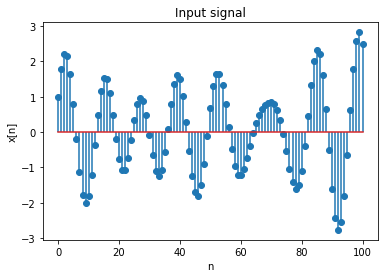

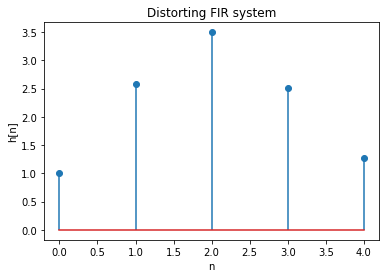

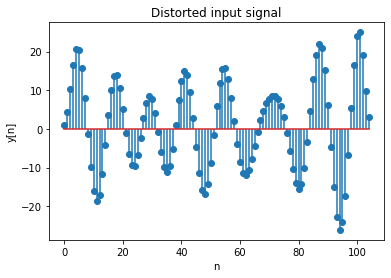

In [33]:
#The below function is just an aid to obtain h[n] from given H(z). This was utilised because of repition of similar
#computational methods.

def distortionfilter_gen(zeros):
    p4 = zeros[0]*zeros[1]*zeros[2]*zeros[3]
    p3 = p4*(1/zeros[0]+1/zeros[1]+1/zeros[2]+1/zeros[3])
    p2 = zeros[0]*zeros[1] + zeros[0]*zeros[2] + zeros[0]*zeros[3]+ zeros[1]*zeros[2] + zeros[1]*zeros[3]+ zeros[2]*zeros[3]
    p1 = zeros[0]+zeros[1]+zeros[2]+zeros[3]
    
    return np.array([1, -1*p1, p2, -1*p3, p4])

h=distortionfilter_gen([0.9*np.exp(0.6j*np.pi), 0.9*np.exp(-0.6j*np.pi), 1.25*np.exp(0.8j*np.pi), 1.25*np.exp(-0.8j*np.pi)])

h = h.astype(np.float64) #Neglecting very small imaginary parts

N = 100 #Since the signal choosen is Infinite Right sided sequence we are choosing only N values for illustraion

n = np.linspace(0, N, N+1)

x = np.sin(np.pi*n/6) + np.sin(np.pi*n/8) + np.cos(np.pi*n/7) 

#Convolving the distortion FIR system on input signal
y = convolve(x, h, plot=False)

plt.rcParams['figure.figsize'] = [6, 4]
plt.figure()
plt.title('Input signal')
plt.xlabel('n')
plt.ylabel('x[n]')
plt.stem(n, x)

plt.figure()
plt.title('Distorting FIR system')
plt.xlabel('n')
plt.ylabel('h[n]')
plt.stem(h)

plt.figure()
plt.title('Distorted input signal')
plt.xlabel('n')
plt.ylabel('y[n]')
plt.stem(y)

## Observations
* Clearly the magnitude is amplified.
* There is some shift in waveform also.

# Question 2

Here the distorted signal is beign passed to a inverse filter of minimum phase factor of H(z) which is 

G(z) = $H_{min}(z)$ = $\frac{(0.8)^2}{( 1 − 0.9e^{j0.6π}z^{−1} )(1 − 0.9e^{−j0.6π}z^{−1})(1 − 0.8e^{j0.8π}z^{−1})(1 −
0.8e^{−j0.8π}z^{−1})}$

Its time domain sequence is calculated  manualy and with some computational tools. And since the obtained time domain sequence is IIR system so we used N values inorder to mimic the infinite behaviour.

## x^$[n]$ = y$[n]$ * g$[n]$

<StemContainer object of 3 artists>

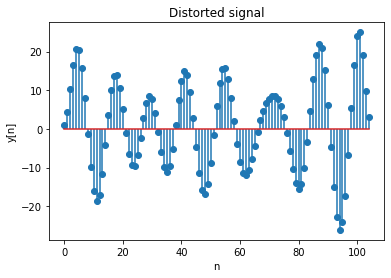

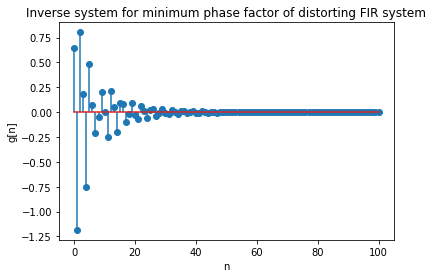

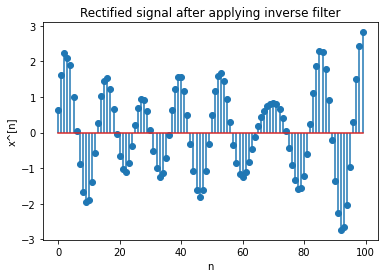

In [34]:
g = -1*np.power((- 0.27811529493745262842097076827486 - 0.8559508646656383001882772987301j),n)*(0.14663288710561474694866337150187 + 0.34062336288391083028618212680458j) - np.power((- 0.27811529493745262842097076827486 + 0.8559508646656383001882772987301j), n)*(0.14663288710561474694866337150187 - 0.34062336288391083028618212680458j) + np.power((- 0.64721359549995793880583505597315 - 0.47022820183397862070506789677893j), n)*(0.46663288710561474694866337150187 - 0.083838714358561967363412760930737j) + np.power((- 0.64721359549995793880583505597315 + 0.47022820183397862070506789677893j), n)*(0.46663288710561474694866337150187 + 0.083838714358561967363412760930737j)
g = np.real(g)

xt = convolve(y, g, plot=False)

plt.figure()
plt.title('Distorted signal')
plt.xlabel('n')
plt.ylabel('y[n]')
plt.stem(y)

plt.figure()
plt.title('Inverse system for minimum phase factor of distorting FIR system')
plt.xlabel('n')
plt.ylabel('g[n]')
plt.stem(g)

plt.figure()
plt.title('Rectified signal after applying inverse filter')
plt.xlabel('n')
plt.ylabel('x^[n]')
plt.stem(xt[:100])

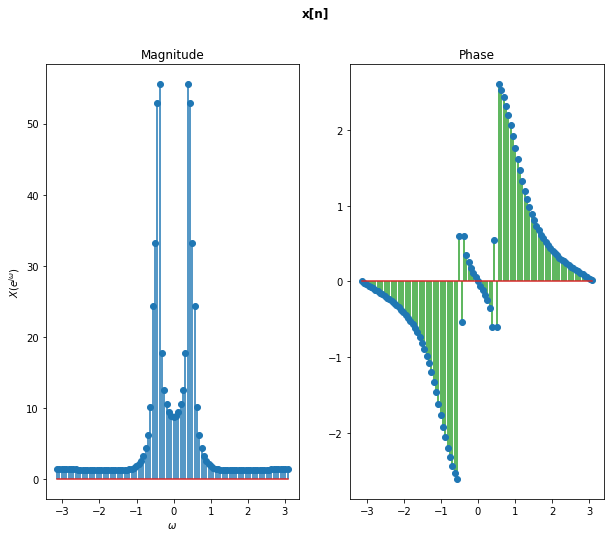

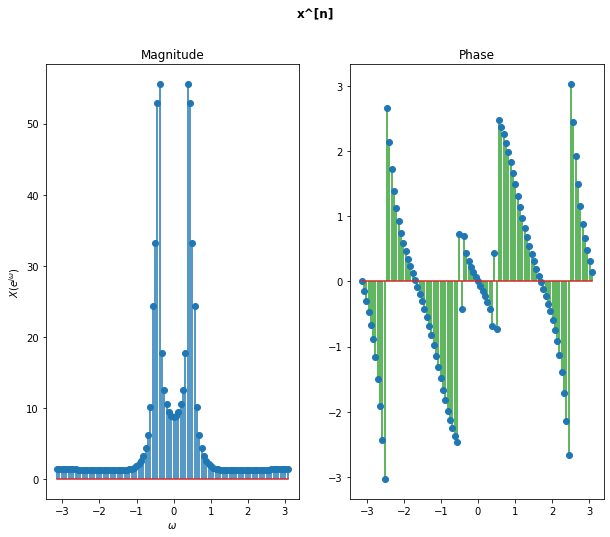

In [35]:
dtft_plotter(dtft(x), complex_part=False, title='x[n]')
dtft_plotter(dtft(xt), complex_part=False, title='x^[n]')

## Observations
* The Magnitude is obtained as it is since the effective system can be modeled as an all-pass system which does'nt affect magnitude.
* The phase is completely distorted because of non-zero phase of all-pass filter

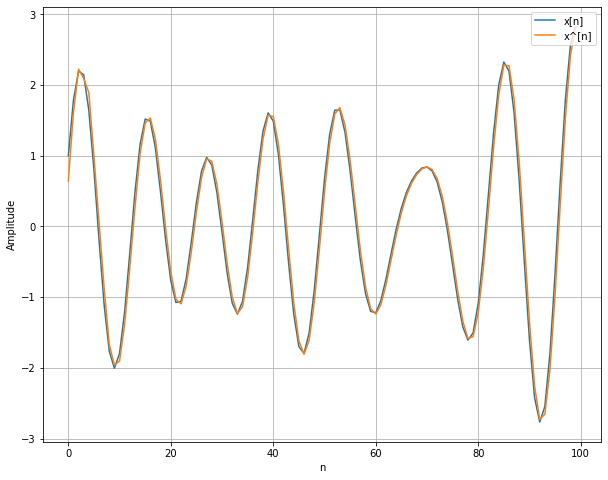

In [40]:
plt.plot(x[:100], label='x[n]')
plt.plot(xt[:100], label='x^[n]')
plt.ylabel('Amplitude')
plt.xlabel('n')
plt.grid()
plt.legend(loc=1)

## Observations
We can only observe see that at some places the signal is beign delayed. If there can be space for slight waveform change then this process of undoing the distortion effect can be achivied.

# Question 3

Same code as in HW3 is beign used and obtained the following results.

There might be some spikes in group delay plots due to truncation errors of computing numerical derivaties for group delay.

## (a) h[n] = u[n] - u[n-5]

(0.0, 2.0)

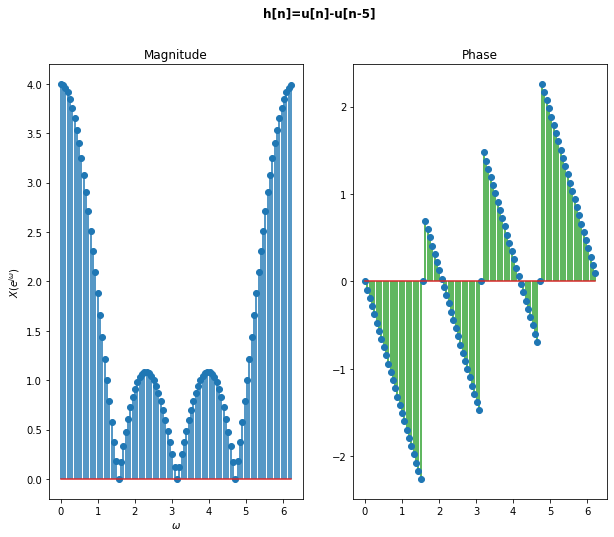

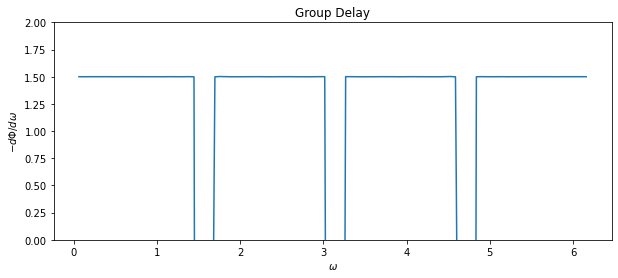

In [50]:
h = np.array([1, 1, 1, 1])

H = dtft(h, low_lim=0, high_lim=2*np.pi)
dtft_plotter(H, complex_part=False, title='h[n]=u[n]-u[n-5]')

plt.rcParams['figure.figsize'] = [10, 4]
plt.figure()
plt.title('Group Delay')
plt.ylabel('$-d{\Phi}/d{\omega}$')
plt.xlabel('$\omega$')
plt.plot(H['omega'][1:-1], group_delay(H['phase'], H['omega']))
plt.ylim((0, 2))

## (b) h[n] = u[n] - u[n-6]

(1.0, 3.0)

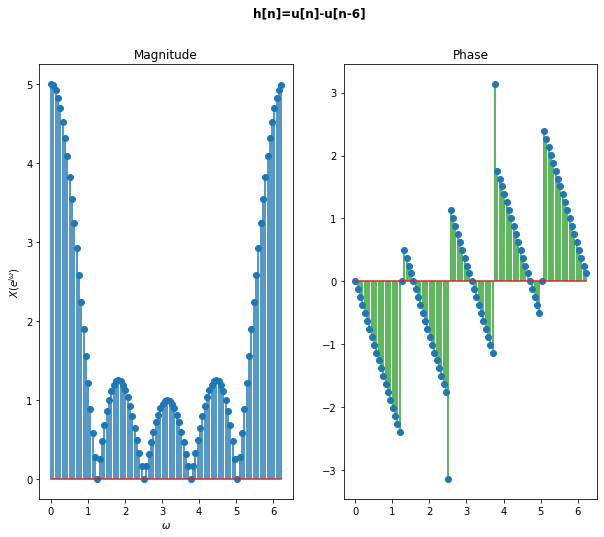

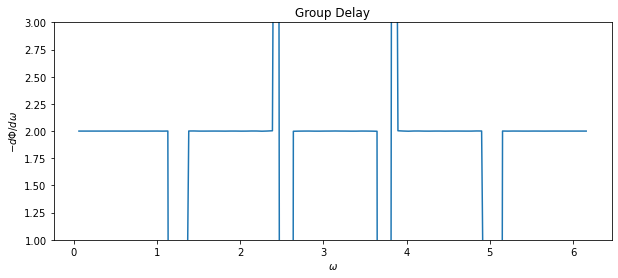

In [52]:
h = np.array([1, 1, 1, 1, 1])

H = dtft(h, low_lim=0, high_lim=2*np.pi)

dtft_plotter(H, complex_part=False, title='h[n]=u[n]-u[n-6]')

plt.rcParams['figure.figsize'] = [10, 4]
plt.figure()
plt.title('Group Delay')
plt.ylabel('$-d{\Phi}/d{\omega}$')
plt.xlabel('$\omega$')
plt.plot(H['omega'][1:-1], group_delay(H['phase'], H['omega']))
plt.ylim((1, 3))

## (c) $h[n] = \delta[n] - \delta[n-2]$

(0.0, 2.0)

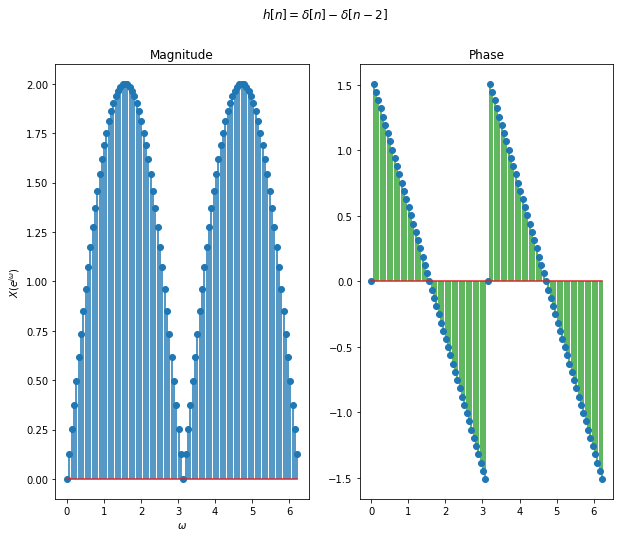

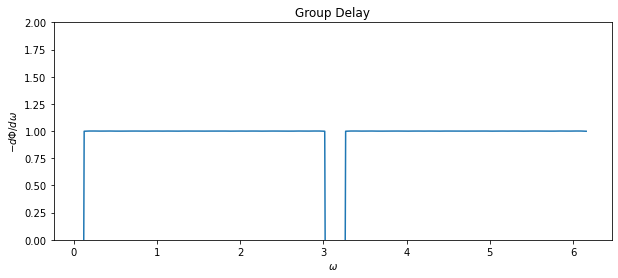

In [58]:
h = np.array([1, 0,-1])

H = dtft(h, low_lim=0, high_lim=2*np.pi)

dtft_plotter(H, complex_part=False, title='$h[n] = \delta[n] - \delta[n-2]$')

plt.rcParams['figure.figsize'] = [10, 4]
plt.figure()
plt.title('Group Delay')
plt.ylabel('$-d{\Phi}/d{\omega}$')
plt.xlabel('$\omega$')
plt.plot(H['omega'][1:-1], group_delay(H['phase'], H['omega']))
plt.ylim((0, 2))

## (d) $h[n] = \delta[n] - \delta[n-1]$

(0.0, 1.0)

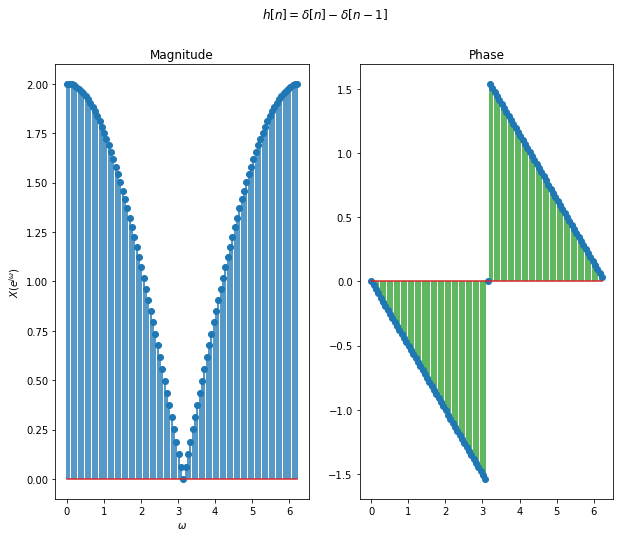

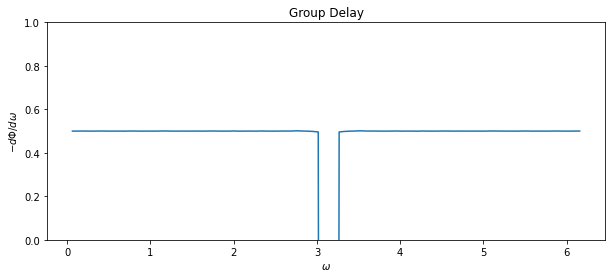

In [57]:
h = np.array([1, 1])

H = dtft(h, low_lim=0, high_lim=2*np.pi)

dtft_plotter(H, complex_part=False, title='$h[n] = \delta[n] - \delta[n-1]$')

plt.rcParams['figure.figsize'] = [10, 4]
plt.figure()
plt.title('Group Delay')
plt.ylabel('$-d{\Phi}/d{\omega}$')
plt.xlabel('$\omega$')
plt.plot(H['omega'][1:-1], group_delay(H['phase'], H['omega']))
plt.ylim((0, 1))